# Analysis with Proper Orthogonal Decomposition

Here we will use a classical method to obtained our reduced order model of the Kolmogorov flow based on Proper Orthogonal Decomposition.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import librairies

In [5]:
import os
import numpy as np
import argparse
from numpy import linalg as LA
import matplotlib.pyplot as plt
import h5py

# 2. Read dataset

In [7]:
hf = h5py.File('/content/drive/MyDrive/Kolmogorov_Re50.0_T2000_DT01.h5','r')
print(hf)
Nx = 24
Nu = 1
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
# if Nu ==2:
#     u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
hf.close()
print(u_all.shape)


# normalize data
u_min = np.amin(u_all[:,:,:,0])
u_max = np.amax(u_all[:,:,:,0])
u_all[:,:,:,0] = (u_all[:,:,:,0] - u_min) / (u_max - u_min)
# if Nu==2:
#     v_min = np.amin(u_all[:,:,:,1])
#     v_max = np.amax(u_all[:,:,:,1])
#     u_all[:,:,:,1] = (u_all[:,:,:,1] - v_min) / (v_max - v_min)

<HDF5 file "Kolmogorov_Re50.0_T2000_DT01.h5" (mode r)>
(1000, 24, 24, 1)


# 3. Compute POD modes

In [8]:
Ntrain = 700
dim = u_all.shape

UU = np.reshape(u_all[:Ntrain,:],(Ntrain,dim[1]*dim[2]*dim[3]))
m = UU.shape[0]
C = np.matmul(np.transpose(UU),UU)/(m-1)

#solve eigenvalue problem
eig, phi = LA.eigh(C)

#Sort Eigenvalues and vectors
idx = eig.argsort()[::-1]
eig = eig[idx]
phi = phi[:, idx]

#project onto modes for temporal coefficients
a = np.matmul(UU,phi) # contains the "code" (modal coefficients)


phi_spat = np.reshape(phi,(dim[1],dim[2],dim[1]*dim[2])) # contains the spatial mode

print("check orthogonality")
print(np.matmul(np.transpose(phi),phi))

print("relative contribution of eigenvalues")
contrib = eig/np.sum(eig)

check orthogonality
[[ 1.00000000e+00  3.46944695e-16  5.55111512e-17 ... -6.07153217e-17
   1.69135539e-17  3.98986399e-17]
 [ 3.46944695e-16  1.00000000e+00  2.35922393e-16 ... -2.77555756e-16
   1.12106505e-16  4.33680869e-17]
 [ 5.55111512e-17  2.35922393e-16  1.00000000e+00 ... -2.94902991e-16
  -4.33680869e-18  4.68375339e-17]
 ...
 [-6.07153217e-17 -2.77555756e-16 -2.94902991e-16 ...  1.00000000e+00
  -2.60642202e-16  8.67361738e-17]
 [ 1.69135539e-17  1.12106505e-16 -4.33680869e-18 ... -2.60642202e-16
   1.00000000e+00  1.70219741e-17]
 [ 3.98986399e-17  4.33680869e-17  4.68375339e-17 ...  8.67361738e-17
   1.70219741e-17  1.00000000e+00]]
relative contribution of eigenvalues


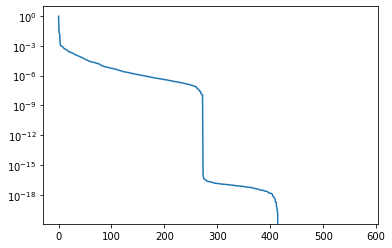

In [9]:
%matplotlib inline
plt.figure()
plt.semilogy(contrib) # plot the contribution of each mode to the overall energy

# print("size of coefficients")
# print(a.shape)

# print("size of input")
# print(UU.shape)

# 4. Visualization of some modes and error computation

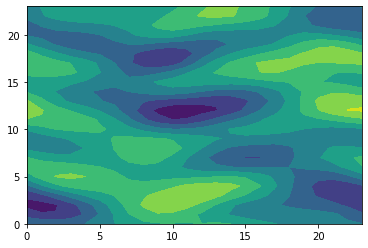

In [10]:
imode = 5
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(phi_spat[:,:,imode])

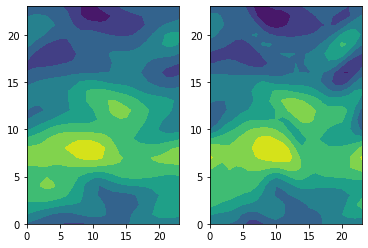

In [11]:
# Visualization of modal reconstruction with truncated number of modes
isample = 50
nmodes = 20

# To reconstruct the field ("decode"), we just matrix-multiply the modal coefficients with the spatial modes
# but we do that for a truncated number of modes, instead of using the full modes
recons = np.matmul(a[:,:nmodes],np.transpose(phi[:,:nmodes]))


fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(np.reshape(recons[isample,:],(dim[1],dim[2])))
ax = fig.add_subplot(122)
ax.contourf(np.reshape(UU[isample,:],(dim[1],dim[2])))

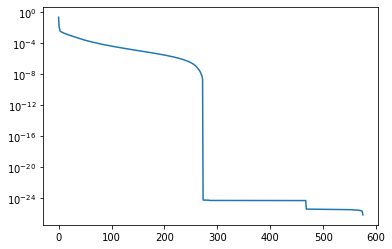

In [12]:
# Mean reconstruction error for different number of retained modes
# We can compute the reconstruction of a varying number of modes and compute the error with our original data
err = np.zeros((dim[1]*dim[2]))
for i in range(dim[1]*dim[2]):
    recons = np.matmul(a[:,:i],np.transpose(phi[:,:i]))
    err[i] = np.mean(np.mean(np.square(UU - recons)))

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(err)

# 5. Projection of the validation data onto truncated mode and error assessment 

(3300, 576)


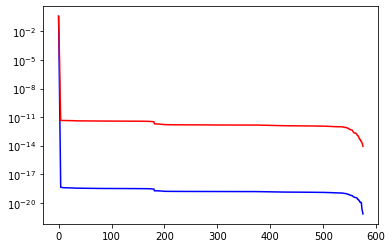

In [ ]:
UU_valid = np.reshape(u_all[Ntrain:,:],(dim[0]-Ntrain,dim[1]*dim[2]*dim[3]))
a_valid = np.matmul(UU_valid,phi)

print(UU_valid.shape)

# Mean reconstruction error for different number of retained modes
err_valid = np.zeros((dim[1]*dim[2]))
for i in range(dim[1]*dim[2]):
    recons = np.matmul(a_valid[:,:i],np.transpose(phi[:,:i]))
    err_valid[i] = np.mean(np.mean(np.square(UU_valid - recons)))

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(err,'b')
ax.semilogy(err_valid,'r')


6. POD errror for given number of nodes

In [ ]:
nmodes = 1
print(err_valid[nmodes])

0.0008800398698258046
